# Optical Character Recognition

This notebook explores and compares different methods of optical character recognition Tesseract OCR and Google Vision API. OCR is an important tool, if we want to process large quantities of printed or hand-written textual data. The accompanying blog post can be found [here](https://fuzzylabs.ai/blog/the-battle-of-the-ocr-engines/)

The examples provided:
* Sample prescription (amoxicillin, a type of antibiotic): `gs://fuzzylabs-jupyter-delicacies/amoxicillin_prescription.png`
* Receipt from a hotel (with a hand-written note): `gs://fuzzylabs-jupyter-delicacies/receipt.jpg`

You are encouraged to try it on different images (local files and Google Cloud Storage are supported) to experiment and identify which methods and models best suit your needs.

Run this cell to install the necessary packages, if they are not already installed.

In [1]:
!pip install tesserocr matplotlib opencv-python google-cloud-vision gcsfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.1/529.1 kB 33.9 MB/s eta 0:00:00


In [5]:
import io
import matplotlib.pyplot as plt
import cv2

# from cv2 import cv2
import locale
locale.setlocale(locale.LC_ALL, 'C')
from tesserocr import *
from google.cloud import vision
from PIL import Image
import numpy as np
import gcsfs

In [8]:
# def show_image(img, title=""):
#     plt.figure(figsize=(5,88))
#     plt.imshow(img)
#     plt.title(title)
#     plt.show()

# # Accepts either a local file
# def imread_wrapper(uri):
#     if uri.startswith("gs://"):
#         with gcsfs.GCSFileSystem().open(uri, "rb") as f:
#             arr = np.asarray(bytearray(f.read()), dtype="uint8")
#             img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
#             return img
#     else: # Assume local file
#         return cv2.imread(uri, cv2.IMREAD_COLOR)

def imread_wrapper(uri):
    if uri.startswith("gs://"):
        with gcsfs.GCSFileSystem().open(uri, "rb") as f:
            arr = np.asarray(bytearray(f.read()), dtype="uint8")
            img = cv2.imdecode(arr, cv2.IMREAD_COLOR)
    else:  # local file
        img = cv2.imread(uri, cv2.IMREAD_COLOR)

    if img is None:
        raise ValueError(f"Could not load image: {uri}")
    return img


In [9]:
def show_image(img, title=""):
    plt.figure(figsize=(5, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR -> RGB
    plt.title(title)
    plt.axis('off')
    plt.show()


Load the image (filename specified in `img`) to run the recognition on.

You can optionally set `PERFORM_THRESHOLDING` to `True`, to perform thresholding. It is advised to preprocess an image if there are unwanted objects in the background (e.g. img/amoxicillin_prescription.png)

In [17]:
# PERFORM_THRESHOLDING = False
# img = imread_wrapper("content/DeepSeek_OCR_paper.jpg")
# if PERFORM_THRESHOLDING:
#     _, img = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#     img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
# show_image(img)

PERFORM_THRESHOLDING = False
img = imread_wrapper("/content/DeepSeek_OCR_paper.jpg")

if PERFORM_THRESHOLDING:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    img = cv2.cvtColor(img_thresh, cv2.COLOR_GRAY2BGR)

show_image(img)


In [11]:
!pip install pdf2image
!apt-get install poppler-utils


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.12 [186 kB]
Fetched 186 kB in 1s (323 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.12_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.12) ...
Setting up poppler-utils (22.02.0-2ubuntu0.12) ...
Processing triggers for man-db (2.10.2-1) ...


In [15]:
from pdf2image import convert_from_path

pdf_path = "/content/DeepSeek_OCR_paper.pdf"
pages = convert_from_path(pdf_path)  # returns list of PIL images

# Show first page
pages[0].show()


In [ ]:
import cv2
import numpy as np

# Take first page
pil_img = pages[0]
img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

# Now you can use your show_image function
show_image(img)


# Tesseract OCR

Tesseract can run in different page segmentation modes. In many cases it is enough to run it on auto (PSM.AUTO), but it is often useful to provide it with some hint on what the layout of the input image is.

We consider three modes here:
* `PSM.SINGLE_BLOCK` -- Assume a single uniform block of text.
* `PSM.SPARSE_TEXT` -- Sparse text. Find as much text as possible in no particular order.
* `PSM.SINGLE_COLUMN` -- Assume a single column of text of variable sizes.

The illustration of how they behave is provided below.

One can read more on different PSMs in Tesseract OCR documentation.

In [19]:
!apt-get install -y tesseract-ocr
!apt-get install -y tesseract-ocr-all  # (optional, installs all languages)


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-afr tesseract-ocr-amh tesseract-ocr-ara tesseract-ocr-asm
  tesseract-ocr-aze tesseract-ocr-aze-cyrl tesseract-ocr-bel tesseract-ocr-ben
  tesseract-ocr-bod tesseract-ocr-bos tesseract-ocr-bre tesseract-ocr-bul
  tesseract-ocr-cat tesseract-ocr-ceb tesseract-ocr-ces tesseract-ocr-chi-sim
  tesseract-ocr-chi-sim-vert tesseract-ocr-chi-tra tesseract-ocr-chi-tra-vert
  tesseract-ocr-chr tesseract-ocr-cos tesseract-ocr-cym tesseract-ocr-dan
  tesseract-ocr-deu tesseract-ocr-div tesseract-ocr-dzo tesseract-ocr-ell
  tesseract-ocr-enm tesseract-ocr-epo tesseract-ocr-est tesseract-ocr-eus
  tesseract-ocr-fao t

In [21]:
!tesseract --print-parameters | grep 'TESSDATA_PREFIX'


In [22]:
from tesserocr import PyTessBaseAPI, PSM

tessdata_dir = "/usr/share/tesseract-ocr/4.00/tessdata"

tesseract_modes = [
    ("Tesseract SINGLE BLOCK", PyTessBaseAPI(psm=PSM.SINGLE_BLOCK, path=tessdata_dir)),
    ("Tesseract SPARSE TEXT", PyTessBaseAPI(psm=PSM.SPARSE_TEXT, path=tessdata_dir)),
    ("Tesseract SINGLE COLUMN", PyTessBaseAPI(psm=PSM.SINGLE_COLUMN, path=tessdata_dir))
]


In [30]:
# def tesseract_ocr(tesseract, img):
#     pil_image = Image.fromarray(img)
#     tesseract.SetImage(pil_image)
#     tesseract.Recognize()
#     return tesseract.GetIterator()

# def display_tesseract_results(img, level):
#     n = len(tesseract_modes)
#     fig, axs = plt.subplots(1,n, figsize=(5*n, 88))
#     for (name, tesseract), ax in zip(tesseract_modes, axs):
#         results = tesseract_ocr(tesseract, img)
#         _img = img.copy()
#         tokens = []
#         for r in iterate_level(results, level):
#             text = r.GetUTF8Text(level)
#             tokens += [text]
#             bb = r.BoundingBox(level)
#             cv2.rectangle(_img, (bb[0], bb[1]), (bb[2], bb[3]), (255, 0, 0), 2)
#         print(name)
#         print(tokens)
#         print()
#         ax.set_title(name)
#         ax.imshow(_img)

def tesseract_ocr(tesseract, img):
    if img is None:
        raise ValueError("Input image is None. Cannot perform OCR.")

    # Tesseract via PIL expects RGB, OpenCV gives BGR
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(img_rgb)

    tesseract.SetImage(pil_image)
    tesseract.Recognize()
    return tesseract.GetIterator()


def display_tesseract_results(img, level):
    if img is None:
        print("Error: Image is None. Skipping Tesseract display.")
        return

    n = len(tesseract_modes)
    fig, axs = plt.subplots(1, n, figsize=(5*n, 8))
    if n == 1: axs = [axs] # Handle single axis case

    for (name, tesseract), ax in zip(tesseract_modes, axs):
        try:
            results = tesseract_ocr(tesseract, img)
            _img = img.copy()
            tokens = []
            if results:
                for r in iterate_level(results, level):
                    text = r.GetUTF8Text(level)
                    if text:
                        tokens.append(text.strip())
                    bb = r.BoundingBox(level)
                    if bb:
                        cv2.rectangle(_img, (bb[0], bb[1]), (bb[2], bb[3]), (255, 0, 0), 2)

            print(f"--- {name} ---")
            print(tokens)
            print()
            ax.set_title(name)
            ax.imshow(cv2.cvtColor(_img, cv2.COLOR_BGR2RGB))
            ax.axis('off')
        except Exception as e:
            print(f"Error in {name}: {e}")

Successfully converted PDF. Total pages: 22

--- Processing Page 1 ---
Text detected:
ay deepseek

DeepSeek-OCR: Contexts Optical Compression

Haoran Wei, Yaofeng Sun, Yukun Li

DeepSeek-AI

Abstract

We present DeepSeek-OCR as an initial investigation into the feasibility of compressi...



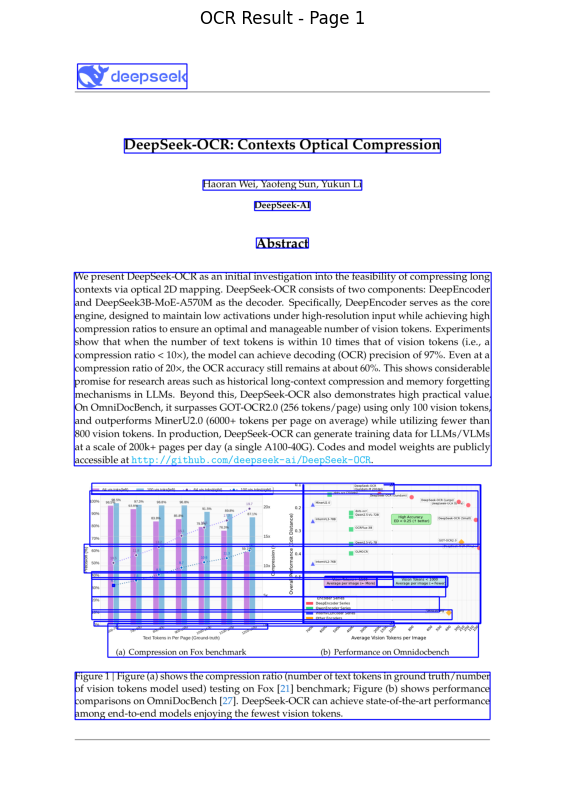

In [38]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
# Added 'iterate_level' to the imports
from tesserocr import PyTessBaseAPI, PSM, RIL, iterate_level
from PIL import Image

# --- 1. Configuration ---
pdf_path = "/content/DeepSeek_OCR_paper.pdf"
tessdata_path = "/usr/share/tesseract-ocr/4.00/tessdata"

# Verify paths
if not os.path.exists(tessdata_path):
    tessdata_path = "/usr/share/tesseract-ocr/tessdata" # Fallback

def show_image(img_arr, title=""):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- 2. Main Processing ---
if not os.path.exists(pdf_path):
    print(f"Error: File not found at {pdf_path}")
else:
    try:
        pages = convert_from_path(pdf_path, dpi=300)
        print(f"Successfully converted PDF. Total pages: {len(pages)}")

        with PyTessBaseAPI(path=tessdata_path, psm=PSM.AUTO) as api:

            for i, page_pil in enumerate(pages):
                print(f"\n--- Processing Page {i + 1} ---")

                # 1. Recognize Text
                api.SetImage(page_pil)
                api.Recognize()

                # Print text snippet
                text = api.GetUTF8Text()
                print(f"Text detected:\n{text[:200]}...\n")

                # 2. Visualization
                # Convert PIL -> OpenCV (BGR) for drawing
                open_cv_image = cv2.cvtColor(np.array(page_pil), cv2.COLOR_RGB2BGR)

                iter_ = api.GetIterator()
                level = RIL.PARA  # Paragraph level

                if iter_:
                    # FIX: Use iterate_level() to loop correctly
                    for r in iterate_level(iter_, level):
                        bb = r.BoundingBox(level)
                        if bb:
                            # Draw box: (x1, y1), (x2, y2), Blue, Thickness 4
                            cv2.rectangle(open_cv_image,
                                        (bb[0], bb[1]),
                                        (bb[2], bb[3]),
                                        (255, 0, 0), 4)

                show_image(open_cv_image, f"OCR Result - Page {i + 1}")

                # Remove the break below to process ALL pages
                break

    except Exception as e:
        print(f"An error occurred: {e}")

The results (i.e. recognised texts and their locations) that are returned by Tesseract are arranged in a hierarchy, and therefore can be accessed at different levels. In this notebook, we show the results by paragraph, text line and word. One may find other levels (namely blocks of text and characters) useful for their application.

## By paragraph

Converting PDF to images (this may take a moment)...
Loaded 3 pages.
Processing Page 1 / 3 ...


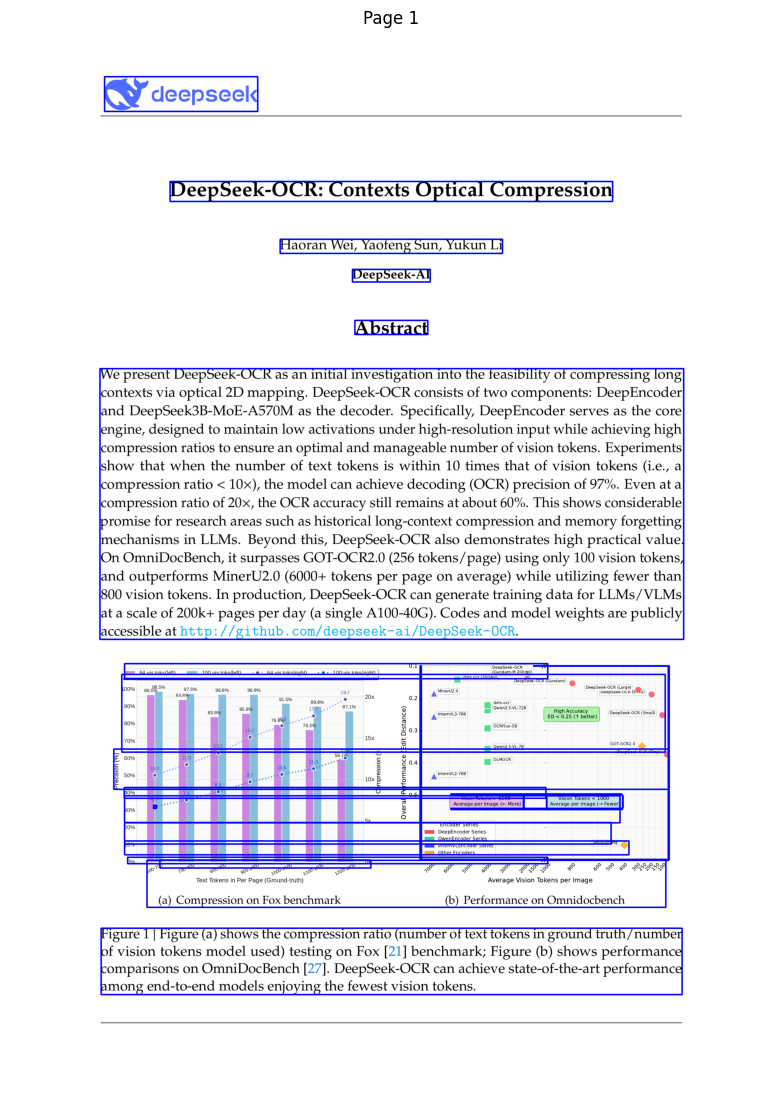

Processing Page 2 / 3 ...


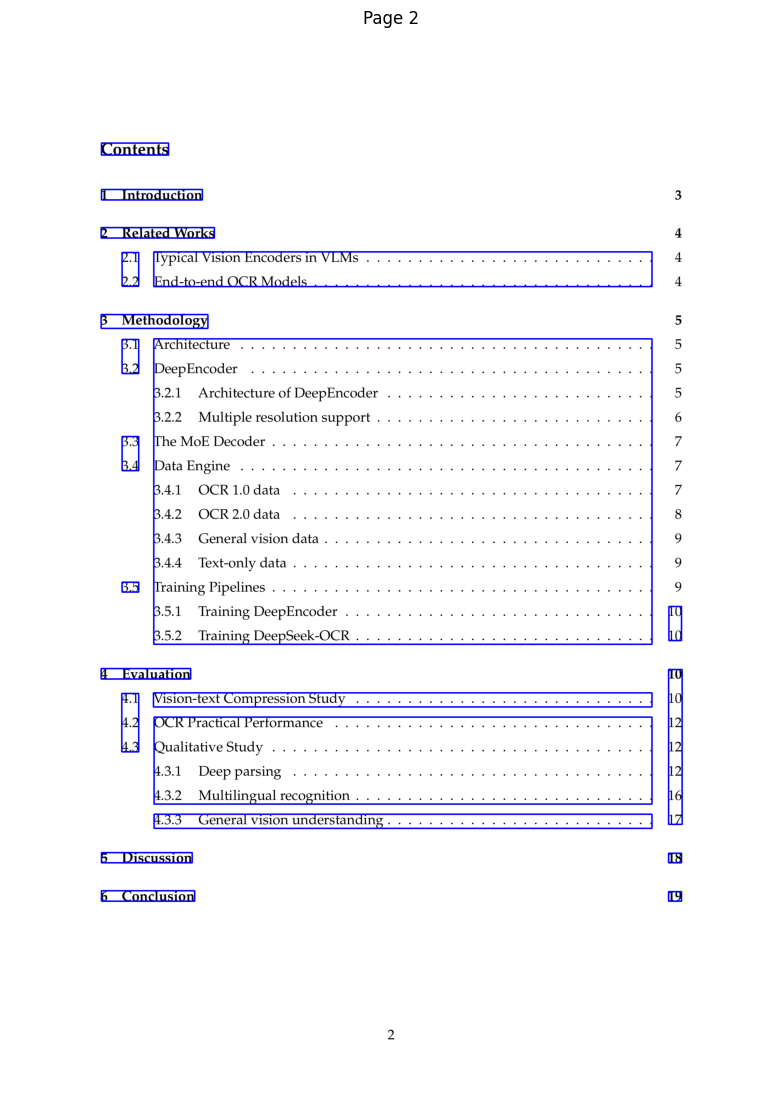

Processing Page 3 / 3 ...


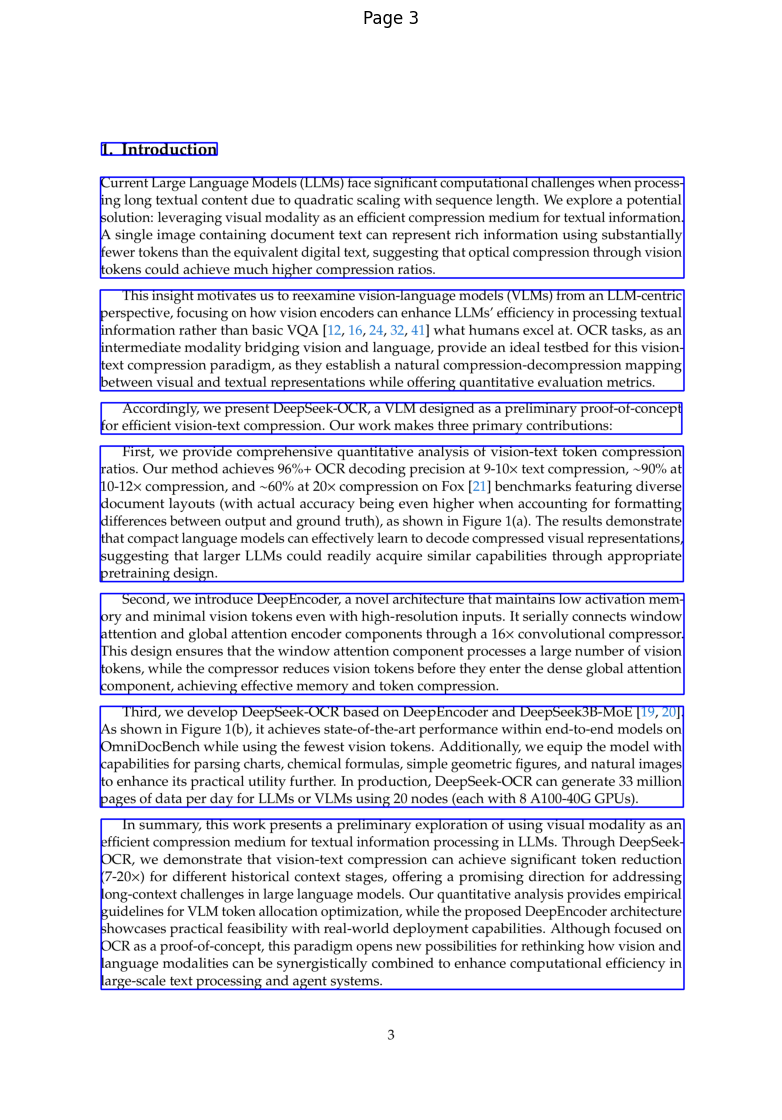

In [42]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tesserocr import PyTessBaseAPI, PSM, RIL, iterate_level
from pdf2image import convert_from_path
import os

# --- Configuration ---
pdf_path = "/content/DeepSeek_OCR_paper.pdf"
tessdata_path = "/usr/share/tesseract-ocr/4.00/tessdata"

# Verify paths
if not os.path.exists(tessdata_path):
    tessdata_path = "/usr/share/tesseract-ocr/tessdata"

# --- Display Function ---
def display_page_result(api, pil_image, page_num):
    # 1. Feed image to Tesseract
    api.SetImage(pil_image)
    api.Recognize()

    # 2. Convert to OpenCV format to draw boxes
    # PIL (RGB) -> Numpy -> OpenCV (BGR)
    img_cv = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)

    # 3. Draw boxes around Paragraphs
    it = api.GetIterator()
    if it:
        for r in iterate_level(it, RIL.PARA):
            bb = r.BoundingBox(RIL.PARA)
            if bb:
                # Draw Blue Rectangle
                cv2.rectangle(img_cv, (bb[0], bb[1]), (bb[2], bb[3]), (255, 0, 0), 4)

    # 4. Show Image
    plt.figure(figsize=(10, 14))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.title(f"Page {page_num}")
    plt.axis('off')
    plt.show()

# --- Main Execution ---

if os.path.exists(pdf_path):
    print("Converting PDF to images (this may take a moment)...")
    # Convert only first 3 pages to save memory using 'last_page' parameter
    pages = convert_from_path(pdf_path, dpi=300, first_page=1, last_page=3)

    print(f"Loaded {len(pages)} pages.")

    # Initialize Tesseract API once
    with PyTessBaseAPI(path=tessdata_path, psm=PSM.AUTO) as api:

        for i, page in enumerate(pages):
            print(f"Processing Page {i + 1} / 3 ...")
            display_page_result(api, page, i + 1)

else:
    print("Error: PDF file not found.")

In [35]:
display_tesseract_results(img, RIL.PARA)

Error: Image is None. Skipping Tesseract display.


## By text line

Visualizing Text Lines (RIL.TEXTLINE)...


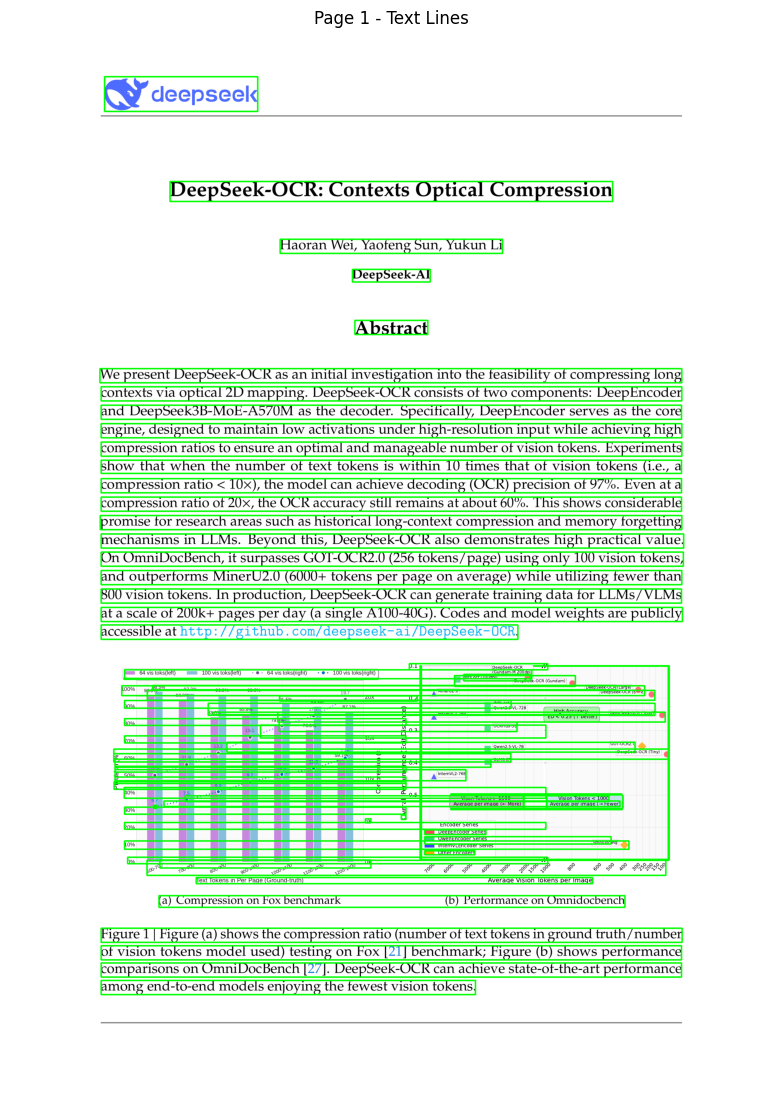

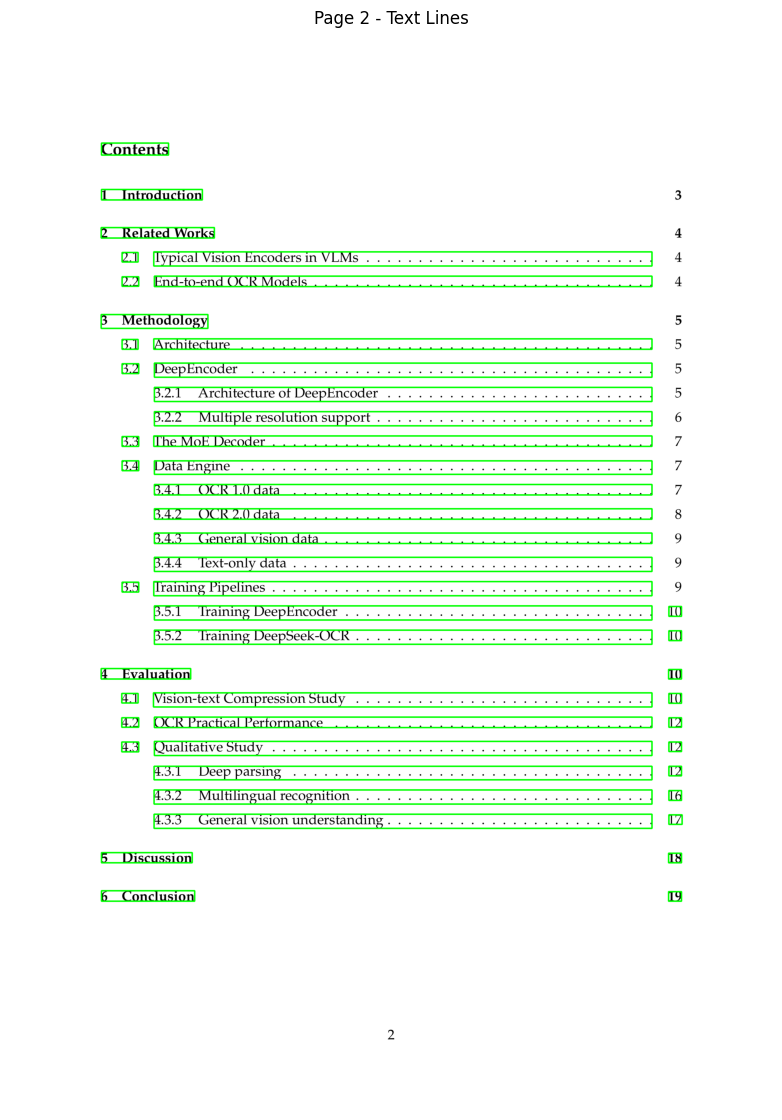

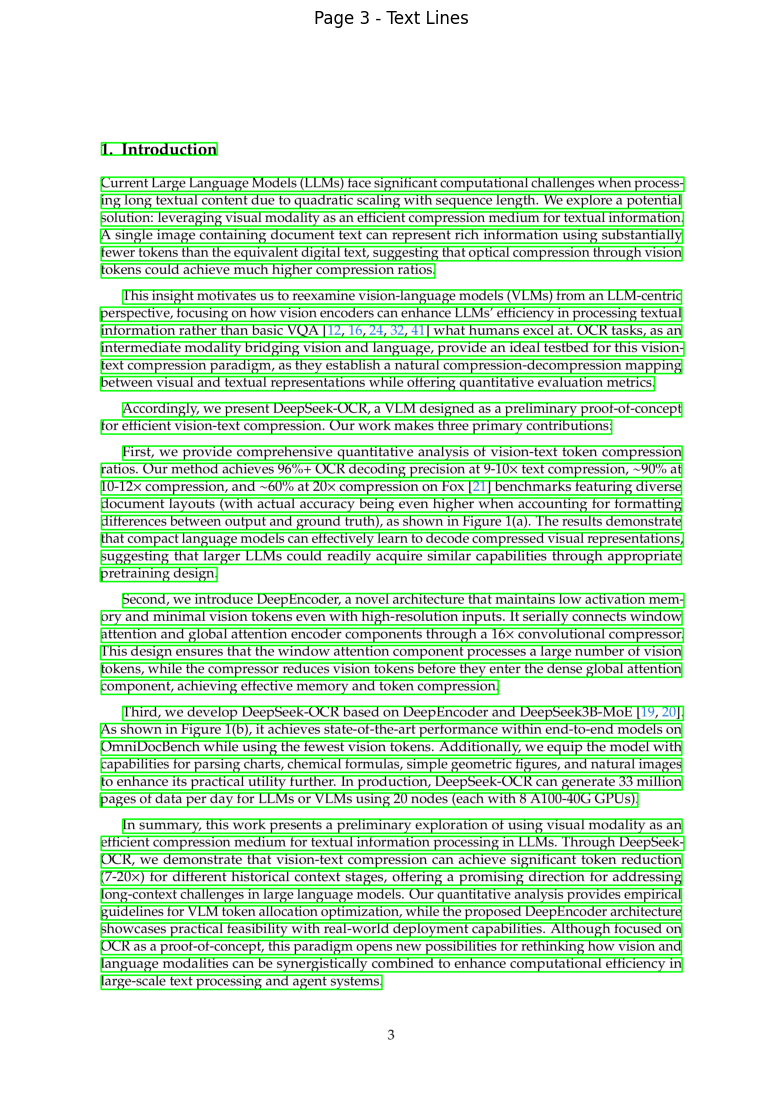

In [43]:
# --- Display TEXT LINES (Green) ---

print("Visualizing Text Lines (RIL.TEXTLINE)...")

with PyTessBaseAPI(path=tessdata_path, psm=PSM.AUTO) as api:
    for i, page in enumerate(pages):
        # 1. OCR Processing
        api.SetImage(page)
        api.Recognize()

        # 2. Convert to OpenCV format (BGR)
        img_cv = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)

        # 3. Draw Green Boxes for Lines
        it = api.GetIterator()
        if it:
            for r in iterate_level(it, RIL.TEXTLINE):
                bb = r.BoundingBox(RIL.TEXTLINE)
                if bb:
                    # Color: Green (0, 255, 0)
                    cv2.rectangle(img_cv, (bb[0], bb[1]), (bb[2], bb[3]), (0, 255, 0), 3)

        # 4. Show Image
        plt.figure(figsize=(10, 14))
        plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
        plt.title(f"Page {i+1} - Text Lines")
        plt.axis('off')
        plt.show()

In [36]:
display_tesseract_results(img, RIL.TEXTLINE)

Error: Image is None. Skipping Tesseract display.


## By word

Visualizing Words (RIL.WORD)...


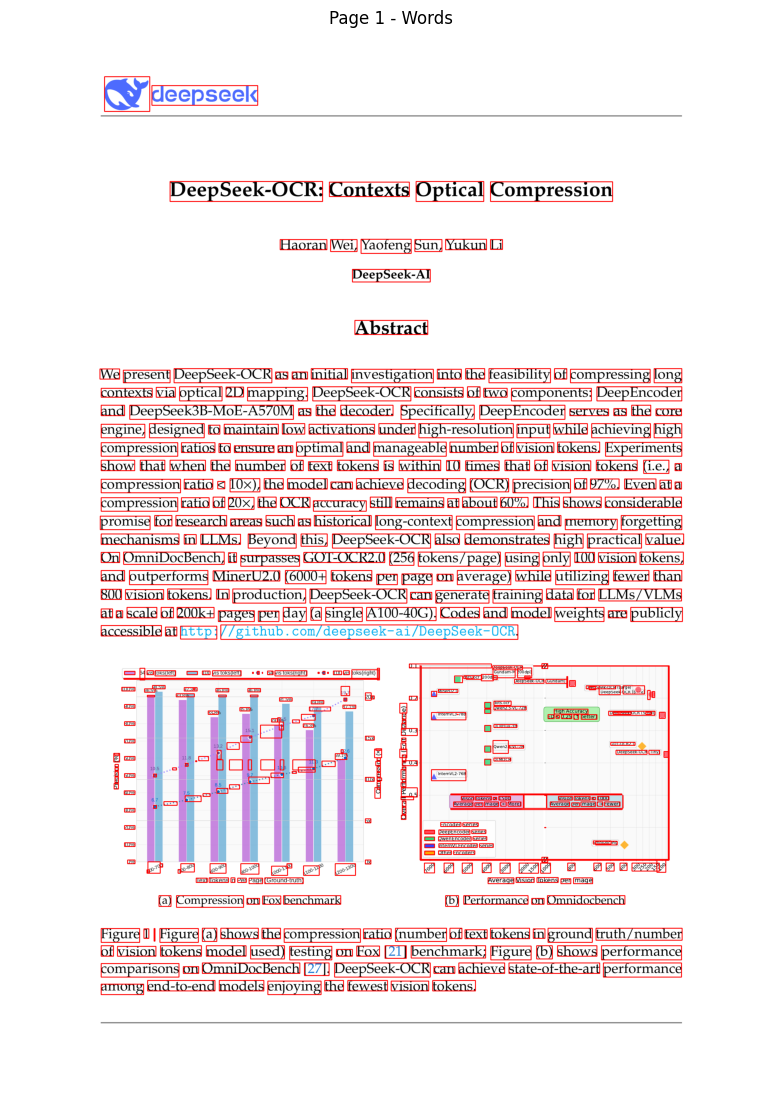

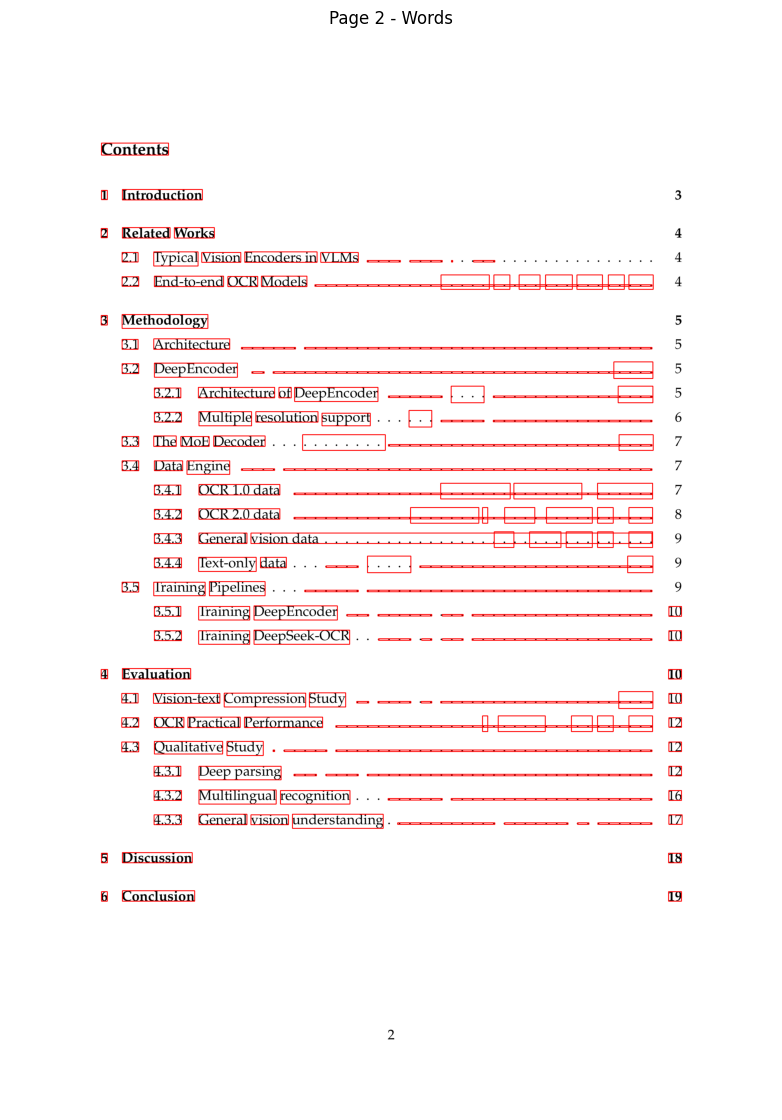

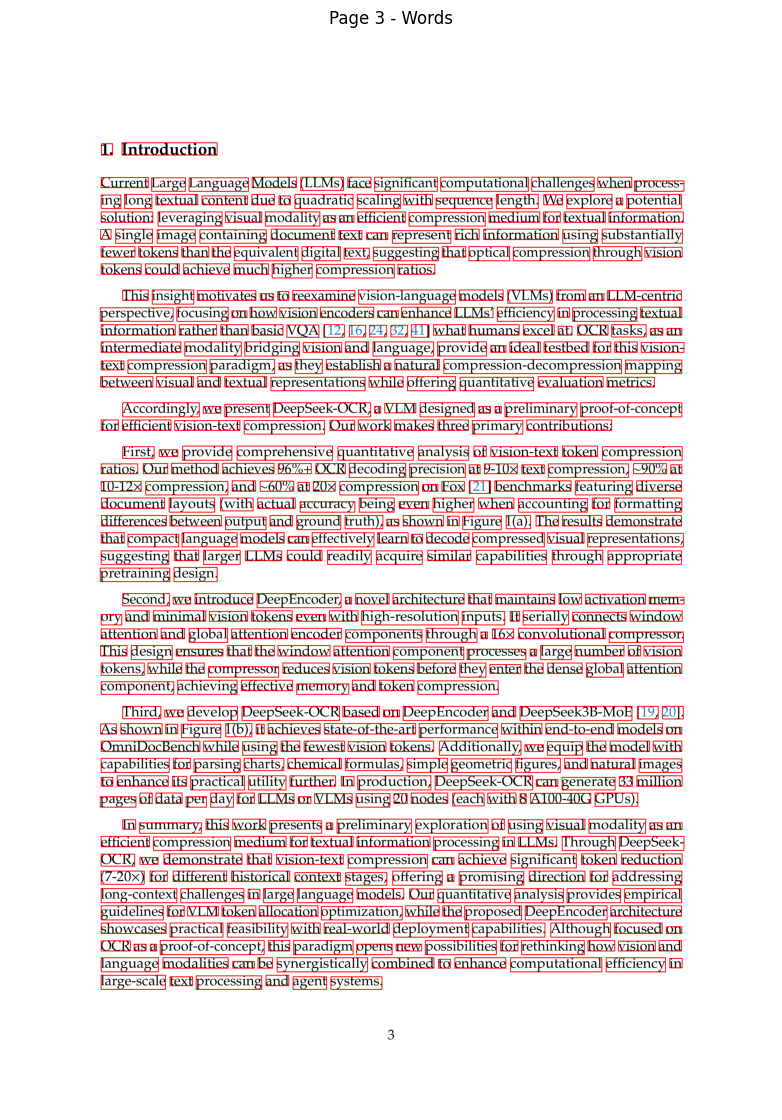

In [44]:
# --- Display WORDS (Red) ---

print("Visualizing Words (RIL.WORD)...")

with PyTessBaseAPI(path=tessdata_path, psm=PSM.AUTO) as api:
    for i, page in enumerate(pages):
        # 1. OCR Processing
        api.SetImage(page)
        api.Recognize()

        # 2. Convert to OpenCV format (BGR)
        img_cv = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)

        # 3. Draw Red Boxes for Words
        it = api.GetIterator()
        if it:
            for r in iterate_level(it, RIL.WORD):
                bb = r.BoundingBox(RIL.WORD)
                if bb:
                    # Color: Red (0, 0, 255)
                    cv2.rectangle(img_cv, (bb[0], bb[1]), (bb[2], bb[3]), (0, 0, 255), 2)

        # 4. Show Image
        plt.figure(figsize=(10, 14))
        plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
        plt.title(f"Page {i+1} - Words")
        plt.axis('off')
        plt.show()

In [37]:
display_tesseract_results(img, RIL.WORD)

Error: Image is None. Skipping Tesseract display.


# DEEPSEEK OCR



**Evaluation**

In [47]:
!pip install jiwer pdfplumber scikit-learn

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_

In [46]:
import pdfplumber
import jiwer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tesserocr import PyTessBaseAPI, PSM
from pdf2image import convert_from_path
import numpy as np

# --- 1. CONFIGURATION ---
pdf_path = "/content/DeepSeek_OCR_paper.pdf"
page_number_to_test = 1  # Which page to evaluate (1-based index)

# --- 2. GET GROUND TRUTH (From PDF Text Layer) ---
# We use pdfplumber to read the actual text stored in the file
ground_truth_text = ""
with pdfplumber.open(pdf_path) as pdf:
    # pdfplumber uses 0-based index
    ground_truth_text = pdf.pages[page_number_to_test - 1].extract_text()

if not ground_truth_text:
    print("WARNING: Could not extract text from PDF layer. Is this a scanned image?")
    ground_truth_text = "Manual ground truth required"

# --- 3. GET TESSERACT OUTPUT ---
# Convert specific page to image
images = convert_from_path(pdf_path, dpi=300, first_page=page_number_to_test, last_page=page_number_to_test)
tess_image = images[0]

tessdata_path = "/usr/share/tesseract-ocr/4.00/tessdata" # Check your path from previous cells
tesseract_text = ""
with PyTessBaseAPI(path=tessdata_path, psm=PSM.AUTO) as api:
    api.SetImage(tess_image)
    api.Recognize()
    tesseract_text = api.GetUTF8Text()

# --- 4. GET DEEPSEEK OUTPUT ---
# PASTE YOUR DEEPSEEK RESULT HERE for the specific page
deepseek_text = """
Paste the text result generated by DeepSeek for this page here.
If you don't have it yet, leave this string empty to skip DeepSeek eval.
"""

# If you haven't pasted anything, we'll copy Tesseract just to prevent errors
if "Paste the text" in deepseek_text:
    print("NOTE: You didn't provide DeepSeek text. Using dummy text for demo.")
    deepseek_text = tesseract_text

# --- 5. CLEANING & NORMALIZATION ---
# Metrics are sensitive to newlines and casing. We normalize them.
transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveMultipleSpaces(),
    jiwer.RemovePunctuation(),
    jiwer.Strip(),
])

# Apply cleaning
gt_clean = transformation(ground_truth_text)
tess_clean = transformation(tesseract_text)
ds_clean = transformation(deepseek_text)

# --- 6. CALCULATE METRICS ---

def calculate_metrics(name, prediction, truth):
    if not prediction or not truth:
        return

    # CER & WER
    cer = jiwer.cer(truth, prediction)
    wer = jiwer.wer(truth, prediction)

    # Cosine Similarity (TF-IDF based)
    vectorizer = TfidfVectorizer().fit_transform([truth, prediction])
    vectors = vectorizer.toarray()
    cosine_sim = cosine_similarity(vectors)[0][1]

    print(f"--- {name} Evaluation ---")
    print(f"CER (Character Error): {cer:.4f}  (Lower is better)")
    print(f"WER (Word Error):      {wer:.4f}  (Lower is better)")
    print(f"Cosine Similarity:     {cosine_sim:.4f}  (Higher is better)")
    print("-" * 30)

print(f"Evaluating Page {page_number_to_test}...\n")

# Run Evaluation
calculate_metrics("Tesseract", tess_clean, gt_clean)
calculate_metrics("DeepSeek", ds_clean, gt_clean)

# Show raw comparison (first 100 chars)
print("\n--- Visual Check (First 100 chars) ---")
print(f"GT:   {gt_clean[:100]}")
print(f"Tess: {tess_clean[:100]}")
print(f"Seek: {ds_clean[:100]}")

NOTE: You didn't provide DeepSeek text. Using dummy text for demo.
Evaluating Page 1...

--- Tesseract Evaluation ---
CER (Character Error): 0.3692  (Lower is better)
WER (Word Error):      1.6393  (Lower is better)
Cosine Similarity:     0.5747  (Higher is better)
------------------------------
--- DeepSeek Evaluation ---
CER (Character Error): 0.3692  (Lower is better)
WER (Word Error):      1.6393  (Lower is better)
Cosine Similarity:     0.5747  (Higher is better)
------------------------------

--- Visual Check (First 100 chars) ---
GT:   deepseekocr contexts optical compression
haoranweiyaofengsunyukunli
deepseekai
abstract
wepresentdee
Tess: ay deepseek deepseekocr contexts optical compression haoran wei yaofeng sun yukun li deepseekai abst
Seek: ay deepseek deepseekocr contexts optical compression haoran wei yaofeng sun yukun li deepseekai abst


# Google Vision API

As an alternative to Tesseract OCR, we also explore Google Vision. As opposed to Tesseract, it does not run locally, but on the Google's servers. In order to use it, valid credentials need to be provided in `GOOGLE_APPLICATION_CREDENTIALS` environment variable (more details in the Google's documentation)



In [ ]:
google_image_annotator = vision.ImageAnnotatorClient()

In [ ]:
def google_document_text_detection(img):
    buf = io.BytesIO()
    img_pil = Image.fromarray(img)
    img_pil.save(buf, 'PNG')
    byte_image = buf.getvalue()

    document_image = vision.types.Image(content=byte_image)
    image_response = google_image_annotator.document_text_detection(image=document_image, image_context={"language_hints": ["en"]})
    page = image_response.full_text_annotation.pages[0]
    return page

def google_text_detection(img):
    buf = io.BytesIO()
    img_pil = Image.fromarray(img)
    img_pil.save(buf, 'PNG')
    byte_image = buf.getvalue()

    document_image = vision.types.Image(content=byte_image)
    image_response = google_image_annotator.text_detection(image=document_image, image_context={"language_hints": ["en"]})
    page = image_response.full_text_annotation.pages[0]
    return page

Google Vision API does not have options for differents modes of page segmentation, however there's still some degree of flexibility provided. There are two models that are tuned on two different tasks:

* Text Detection model -- detects and extracts text from any image
* Document Text Detection model -- performs the same operation, but is tuned for dense texts and documents

The choice of the model depends on the nature and structure of the images to be recognised (same as with PSM of Tesseract OCR). We show the results produced by both models in this notebook.

In [ ]:
pages = [
    ("Google Text Detection", google_text_detection(img)),
    ("Google Document Text Detection", google_document_text_detection(img)),
]

In [ ]:
def get_symbol_text(symbol):
    text = symbol.text
    if symbol.property.HasField('detected_break'):
        if symbol.property.detected_break == vision.enums.TextAnnotation.DetectedBreak.BreakType.LINE_BREAK:
            text += "\n"
        else:
            text += " "
    return text

def get_word_text(word):
    return "".join([get_symbol_text(x) for x in word.symbols])

def get_paragraph_text(para):
    return "".join([get_word_text(x) for x in para.words])

def get_block_text(block):
    return "".join([get_paragraph_text(x) for x in block.paragraphs])

In [ ]:
def add_bounding_box(img, bb):
    cv2.polylines(img, [np.array([[point.x, point.y] for point in bb])], True, (255, 0, 0), 2)


def get_google_words(page, img):
    _img = img.copy()
    texts = []
    for block in page.blocks:
        for para in block.paragraphs:
            for word in para.words:
                texts += [get_word_text(word)]
                add_bounding_box(_img, word.bounding_box.vertices)
    return texts, _img

def get_google_paragraphs(page, img):
    _img = img.copy()
    texts = []
    for block in page.blocks:
        for para in block.paragraphs:
            texts += [get_paragraph_text(para)]
            add_bounding_box(_img, para.bounding_box.vertices)
    return texts, _img

def get_google_blocks(page, img):
    _img = img.copy()
    texts = []
    for block in page.blocks:
        texts += [get_block_text(block)]
        add_bounding_box(_img, block.bounding_box.vertices)
    return texts, _img

def display_google_results(pages, img, func):
    n = len(pages)
    fig, axs = plt.subplots(1,n, figsize=(5*n, 88))
    for (name, page), ax in zip(pages, axs):
        texts, _img = func(page, img)
        print(name)
        print(texts)
        print()
        ax.imshow(_img)
        ax.set_title(name)
    plt.show()

Similar to Tesseract OCR, Google Vision also provides results in a hierarchical manner. Hence, they can be browsed at different levels. As an example, iteration over text blocks, paragraphs and individual words are shown below.

## By text block

In [ ]:
display_google_results(pages, img, get_google_blocks)

## By paragraph

In [ ]:
display_google_results(pages, img, get_google_paragraphs)

## By word

In [ ]:
display_google_results(pages, img, get_google_words)